# CSCI 795 Machine Learning Project
# Survival Prediction of Lung-Cancer Patients One Year After Thoracic Surgery


### The aim of this notebook is to build predictive models to predict the risk of mortality of lung-cancer patients one year after thoracic surgery.

This notebook examines the thoracic dataset and performs a comparative analysis of ML algorithms. We examine multiple classifiers and perform evaluation using performance metrics such as: ROC curve, AUC score, accuracy, precision, recall, and F1 score.

### Dataset

The dataset can be found in the UCI ML repository: https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data

The dataset has 17 features and 1 target vector. The attribute values are mostly categorical and the target values are either T (died) or F (survived).

The imbalance of the class distribution of the target vector is handled by a rebalanacing technique SMOTE. It uses randomization to synthesize data values that lie close to the data values of the minority class.

# Prepare the data through Exploratory Data Analysis (EDA)

### Import libraries

In [226]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression   
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Download and load the dataset

In [227]:
import pandas as pd
df = pd.read_csv('csv_result-ThoraricSurgery.csv', sep=",")

### Generate the top 5 rows of the data

In [228]:
for i in range(df.shape[0]):
    if df['Risk1Yr'][i] == 'T':
        df['Risk1Yr'][i] = 1
    else:
        df['Risk1Yr'][i] = 0

df['Risk1Yr'] = df['Risk1Yr'].apply(pd.to_numeric)
df.head()

,id,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,0
1,2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,0
2,3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,0
3,4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,0
4,5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,1


### Get a description of the data

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       470 non-null    int64  
 1   DGN      470 non-null    object 
 2   PRE4     470 non-null    float64
 3   PRE5     470 non-null    float64
 4   PRE6     470 non-null    object 
 5   PRE7     470 non-null    object 
 6   PRE8     470 non-null    object 
 7   PRE9     470 non-null    object 
 8   PRE10    470 non-null    object 
 9   PRE11    470 non-null    object 
 10  PRE14    470 non-null    object 
 11  PRE17    470 non-null    object 
 12  PRE19    470 non-null    object 
 13  PRE25    470 non-null    object 
 14  PRE30    470 non-null    object 
 15  PRE32    470 non-null    object 
 16  AGE      470 non-null    int64  
 17  Risk1Yr  470 non-null    int64  
dtypes: float64(2), int64(3), object(13)
memory usage: 66.2+ KB


### Get the dimensions of the data

In [230]:
print("Dimension of the data: ", df.shape)

rows = df.shape[0]
cols = df.shape[1]

print("Number of Rows: ", rows)
print("Number of Columns: ", cols)

Dimension of the data:  (470, 18)
Number of Rows:  470
Number of Columns:  18


### Explore the numerical attributes

In [231]:
df.describe()

,id,PRE4,PRE5,AGE,Risk1Yr
count,470.000000,470.000000,470.000000,470.000000,470.000000
mean,235.500000,3.281638,4.568702,62.534043,0.148936
std,135.821574,0.871395,11.767857,8.706902,0.356405
min,1.000000,1.440000,0.960000,21.000000,0.000000
25%,118.250000,2.600000,1.960000,57.000000,0.000000
50%,235.500000,3.160000,2.400000,62.000000,0.000000
75%,352.750000,3.807500,3.080000,69.000000,0.000000
max,470.000000,6.300000,86.300000,87.000000,1.000000


### Explore the categorical attributes

In [232]:
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: DGN
DGN3    349
DGN2     52
DGN4     47
DGN5     15
DGN6      4
DGN8      2
DGN1      1
Name: DGN, dtype: int64

Column Name: PRE6
PRZ1    313
PRZ0    130
PRZ2     27
Name: PRE6, dtype: int64

Column Name: PRE7
F    439
T     31
Name: PRE7, dtype: int64

Column Name: PRE8
F    402
T     68
Name: PRE8, dtype: int64

Column Name: PRE9
F    439
T     31
Name: PRE9, dtype: int64

Column Name: PRE10
T    323
F    147
Name: PRE10, dtype: int64

Column Name: PRE11
F    392
T     78
Name: PRE11, dtype: int64

Column Name: PRE14
OC12    257
OC11    177
OC13     19
OC14     17
Name: PRE14, dtype: int64

Column Name: PRE17
F    435
T     35
Name: PRE17, dtype: int64

Column Name: PRE19
F    468
T      2
Name: PRE19, dtype: int64

Column Name: PRE25
F    462
T      8
Name: PRE25, dtype: int64

Column Name: PRE30
T    386
F     84
Name: PRE30, dtype: int64

Column Name: PRE32
F    468
T      2
Name: PRE32, dtype: int64


##### There are no missing values in the features. However some features are redundant and meaningless. For example, the id feature represents the ID of a patient and has no value for the learning algorithms.

In [233]:
df1 = df.drop(labels=['Risk1Yr'], axis = 1)

# Select only categorical variables
category_df = df1.select_dtypes(['object'])

# One hot encode the variables
dummy_df = pd.get_dummies(category_df)

dummy_df['Risk1Yr'] = df['Risk1Yr']

dummy_df.head()

,DGN_DGN1,DGN_DGN2,DGN_DGN3,DGN_DGN4,DGN_DGN5,DGN_DGN6,DGN_DGN8,PRE6_PRZ0,PRE6_PRZ1,PRE6_PRZ2,...,PRE17_T,PRE19_F,PRE19_T,PRE25_F,PRE25_T,PRE30_F,PRE30_T,PRE32_F,PRE32_T,Risk1Yr
0,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,1,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,1,1,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,1,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,1,0,1


In [234]:
# Combine the one-hot coded categorical features with the numerical features
df = pd.get_dummies(df)

# The absolute values of the correlations will help identify the most correlated features 
most_correlated = df.corr().abs()['Risk1Yr'].sort_values(ascending=False)

print("Most Correlated Features:\n")
print(most_correlated)

Most Correlated Features:

Risk1Yr       1.000000e+00
DGN_DGN5      1.620383e-01
PRE14_OC14    1.430101e-01
DGN_DGN3      1.227236e-01
PRE17_F       1.089745e-01
PRE17_T       1.089745e-01
PRE9_T        1.055298e-01
PRE9_F        1.055298e-01
PRE14_OC11    1.031319e-01
PRE14_OC13    9.619271e-02
PRE10_F       8.885995e-02
PRE10_T       8.885995e-02
PRE11_T       8.646716e-02
PRE11_F       8.646716e-02
PRE30_F       8.595823e-02
PRE30_T       8.595823e-02
DGN_DGN2      8.107019e-02
PRE6_PRZ2     7.650068e-02
id            7.492367e-02
PRE6_PRZ0     7.163255e-02
PRE8_F        6.578470e-02
PRE8_T        6.578470e-02
DGN_DGN8      6.446099e-02
PRE7_T        5.737542e-02
PRE7_F        5.737542e-02
PRE4          4.637386e-02
PRE5          4.284052e-02
AGE           3.890155e-02
DGN_DGN6      3.875753e-02
PRE25_T       3.735413e-02
PRE25_F       3.735413e-02
PRE6_PRZ1     3.019375e-02
PRE19_F       2.734709e-02
PRE19_T       2.734709e-02
PRE32_F       2.734709e-02
PRE32_T       2.734709e-02
D

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          470 non-null    int64  
 1   PRE4        470 non-null    float64
 2   PRE5        470 non-null    float64
 3   AGE         470 non-null    int64  
 4   Risk1Yr     470 non-null    int64  
 5   DGN_DGN1    470 non-null    uint8  
 6   DGN_DGN2    470 non-null    uint8  
 7   DGN_DGN3    470 non-null    uint8  
 8   DGN_DGN4    470 non-null    uint8  
 9   DGN_DGN5    470 non-null    uint8  
 10  DGN_DGN6    470 non-null    uint8  
 11  DGN_DGN8    470 non-null    uint8  
 12  PRE6_PRZ0   470 non-null    uint8  
 13  PRE6_PRZ1   470 non-null    uint8  
 14  PRE6_PRZ2   470 non-null    uint8  
 15  PRE7_F      470 non-null    uint8  
 16  PRE7_T      470 non-null    uint8  
 17  PRE8_F      470 non-null    uint8  
 18  PRE8_T      470 non-null    uint8  
 19  PRE9_F      470 non-null    u

### Explore the target column

In [236]:
df = df.drop(labels=['id', 'DGN_DGN4', 'PRE14_OC12', 'DGN_DGN1'], axis = 1) 

In [237]:
df['Risk1Yr']

0      0
1      0
2      0
3      0
4      1
      ..
465    0
466    0
467    0
468    0
469    0
Name: Risk1Yr, Length: 470, dtype: int64

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PRE4        470 non-null    float64
 1   PRE5        470 non-null    float64
 2   AGE         470 non-null    int64  
 3   Risk1Yr     470 non-null    int64  
 4   DGN_DGN2    470 non-null    uint8  
 5   DGN_DGN3    470 non-null    uint8  
 6   DGN_DGN5    470 non-null    uint8  
 7   DGN_DGN6    470 non-null    uint8  
 8   DGN_DGN8    470 non-null    uint8  
 9   PRE6_PRZ0   470 non-null    uint8  
 10  PRE6_PRZ1   470 non-null    uint8  
 11  PRE6_PRZ2   470 non-null    uint8  
 12  PRE7_F      470 non-null    uint8  
 13  PRE7_T      470 non-null    uint8  
 14  PRE8_F      470 non-null    uint8  
 15  PRE8_T      470 non-null    uint8  
 16  PRE9_F      470 non-null    uint8  
 17  PRE9_T      470 non-null    uint8  
 18  PRE10_F     470 non-null    uint8  
 19  PRE10_T     470 non-null    u

### Check for invalid labels in the target column and find the class distribution

In [239]:
# Counting the invalid values "missing" values in the target column (labels not equal 0 or 1)

count = 0
def invalidValues(frame, column):
    invalid = 0
    for i in range(frame.shape[0]):
        if frame[column][i] != 1 and frame[column][i] != 0:
            invalid = invalid + 1
            
    return invalid

count = invalidValues(df, 'Risk1Yr')

print("Number of missing values in the target Column: ", count)
print("")

# Counting the labels by class
df['Risk1Yr'].value_counts()

true = 0
false = 0

for i in range(df.shape[0]):
    if df["Risk1Yr"][i] == 0:
        false += 1
        
    if df["Risk1Yr"][i] == 1:
        true += 1
print("Number of true instances: ", true)
print("Number of false instances: ", false)
print("")
print("Percentage of true instances: ", round((true * 100)/(true + false), 2), "%")
print("Percentage of false instances: ", round((false * 100)/(true + false), 2), "%")

Number of missing values in the target Column:  0

Number of true instances:  70
Number of false instances:  400

Percentage of true instances:  14.89 %
Percentage of false instances:  85.11 %


### Generate a bar plot of the class distribution

Text(0.5, 1.0, 'Class Distribution')

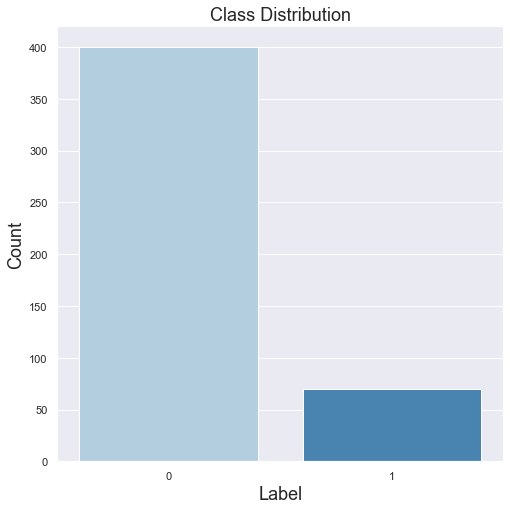

In [240]:
# Bar plot of the class distribution

sn.set(rc={'figure.figsize':(8,8)})
ax = sn.barplot(df['Risk1Yr'].value_counts().index, df['Risk1Yr'].value_counts().values, palette="Blues", capsize=20)
ax.set_xlabel("Label", fontsize=18)
ax.set_ylabel("Count", fontsize=18)

ax.set_title("Class Distribution", fontsize=18)

#### The data is imbalanced - unequal class distribution. The target values are unevenly distributed. 
#### 14.89% of the patients have risk of mortality one year after surgery, whereas 85.11% do not experience the risk of mortality.

### Create a separate feature set (Data Matrix X) and Target (1D Vector y) and print dimension of each. 

In [241]:
y = df['Risk1Yr'] # 1D targer vector
X = df.drop(columns='Risk1Yr')  # Data Matrix of features excluding the target

# Find the dimensions of data matrix X and target vector y
print("Dimension of vector y: ", y.shape + (1,))
print("Dimension of data matrix X: ", X.shape)

Dimension of vector y:  (470, 1)
Dimension of data matrix X:  (470, 34)


In [242]:
# Counting the attribute values by class

counter = Counter(y)
print(counter)

Counter({0: 400, 1: 70})


In [243]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter)

Counter({0: 400, 1: 400})


### Create Train and Test Dataset

In [244]:
# The data matrix X and the 1D vector y are randomly split into training and test sets (80% trainig and 20% test sets)
# The train_test_split method of sklearn library is used for splitting
# The data is randomly shuffled and a seed is used to reproduce the results
# The stratify parameter is set to y since the target exhibits an imbalance in the class distribution
# By default, the train_test_split method will shuffle the data before splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Naive Bayes Classifier (Gaussian NB)

### Model selection and training the Gaussian NB classifier

This model does not perform well on the thoracic dataset since the feature values are mostly categorical, not real-valued. The multinomial NB model performs better as it will be shown next. 

In [245]:
# Gaussian NB classifier is applied in the case of real-valued features

param_grid = {'var_smoothing': [0.000000001, 0.00001, 0.001, 0.01, 0.1, 1.0]}
gnb = GaussianNB() # instantiate the model

gnb = GridSearchCV(gnb, param_grid, scoring='recall', cv=10, verbose=1, n_jobs=-1)
gnb.fit(X_train, y_train)

params_optimal = gnb.best_params_  # find the optimal hyperparameters

print("Best Score (Recall): ", gnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

# Train the model on the optimal hyperparameters

gaussianNB_clf = GaussianNB(**params_optimal)

gaussianNB_clf.fit(X_train, y_train) # fit the optimal model

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Score (Recall):  0.9875
Optimal Hyperparameter Values:  {'var_smoothing': 0.1}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


GaussianNB(var_smoothing=0.1)

### Analyze Model Performance¶

In skewed datasets, accuracy is not a good performance measure, we need to use other performance metrics to evaluate the performance. Evaluate the model using ROC Curve for the training data and then the test data.

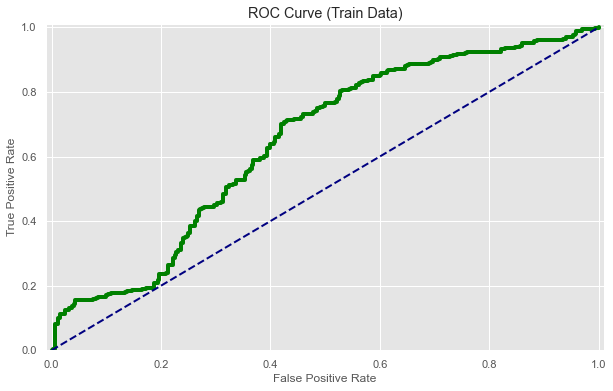

Optimal threshold value: 0.6691823802394171


In [246]:
y_scores = cross_val_predict(gaussianNB_clf, X_train, y_train, method="predict_proba", cv=5)[:, 1]

fpr_GNBTrain, tpr_GNBTrain, thresholds_GNBTrain = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve_train(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='Green', linewidth=4, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim(0, 1.01)
    plt.xlim(-0.01, 1.01)
    

plot_roc_curve_train(fpr_GNBTrain, tpr_GNBTrain)
plt.show()


# Find the minimum distance from the upper left corner (point (0, 1)) to the closes point on the curve
# The point on the curve that corresponds to the minimum distance to the left corner defines the optimal threshold
# Equivalently it can be also defined as the value where the TPR is maximized and the FPR is minimzed

val = np.argmax(tpr_GNBTrain - fpr_GNBTrain)
optimal_threshold = thresholds_GNBTrain[val]
print("Optimal threshold value:", optimal_threshold)

### Compute and print the AUC

In [247]:
# Area under ROC curve
roc_auc_score(y_train, y_scores)

0.6453906250000001

### Plot the precision and recall curve as functions of threshold values

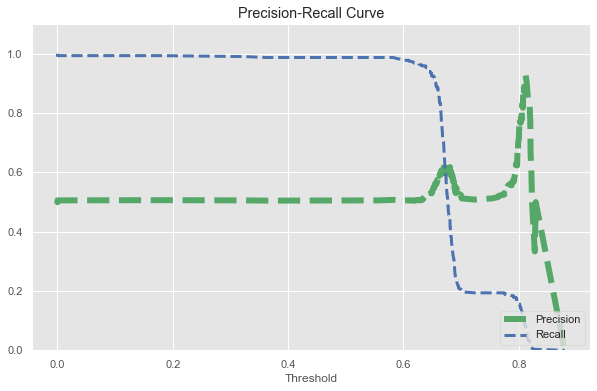

Optimal Threshold:  0.8796365264055571


In [248]:
plt.style.use('ggplot')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "g--",  linewidth=6, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "b--",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
        
threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

### Evaluate the model on Test Data:
### 1. Compute and print the confusion matrix for test data.
### 2. Compute and print the test precision.
### 3. Compute and print the test recall.
### 4. Compute and print the test F1 score.
### 5. Compute and print the test accuracy.

In [249]:
# 'weighted': Calculate metrics for each label, and find their average weighted by support 
# (the number of true instances for each label). This alters ‘macro’ to account for label imbalance;  

y_test_predicted = gaussianNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = ", f1_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Confusion Matrix:
[[ 3 77]
 [ 1 79]]

Test Precision =  0.5125

Test Recall =  0.5125

Test F1 Score =  0.5125

Accuracy:  0.5125

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.04      0.07        80
           1       0.51      0.99      0.67        80

    accuracy                           0.51       160
   macro avg       0.63      0.51      0.37       160
weighted avg       0.63      0.51      0.37       160



### ROC curve for the test data.

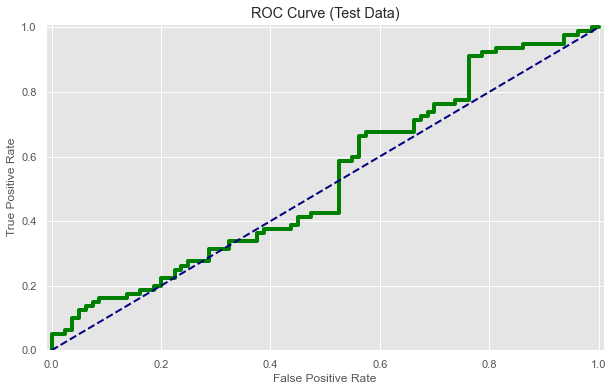

Optimal threshold value: 0.5393469731993727


In [250]:
y_scores_test = cross_val_predict(gaussianNB_clf, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_GNBTest, tpr_GNBTest, thresholds_GNBTest = roc_curve(y_test, y_scores_test)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve_test(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='Green', linewidth=4, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Test Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim(0, 1.01)
    plt.xlim(-0.01, 1.01)
    

plot_roc_curve_test(fpr_GNBTest, tpr_GNBTest)
plt.show()


# Find the minimum distance from the upper left corner (point (0, 1)) to the closes point on the curve
# The point on the curve that corresponds to the minimum distance to the left corner defines the optimal threshold
# Equivalently it can be also defined as the value where the tpr is maximized and the fpr is minimzed

val = np.argmax(tpr_GNBTest - fpr_GNBTest)
optimal_threshold = thresholds_GNBTest[val]
print("Optimal threshold value:", optimal_threshold)

In [251]:
# Area under ROC curve
roc_auc_score(y_test, y_scores_test)

0.5290625

### Multinomial NB: Model Selection

In [252]:
warnings.filterwarnings('ignore')

param_grid = {'alpha': [0.000001, 0.00001, 0.0001, 0.01]}

mnb = MultinomialNB()

mnb = GridSearchCV(mnb, param_grid, scoring='recall', cv=10, verbose=1, n_jobs=-1)
mnb.fit(X_train, y_train)

params_optimal = mnb.best_params_

print("Best Score (Recall): ", mnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")


multinomialNB_clf = MultinomialNB(**params_optimal)

multinomialNB_clf.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Score (Recall):  0.875
Optimal Hyperparameter Values:  {'alpha': 1e-06}




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


MultinomialNB(alpha=1e-06)

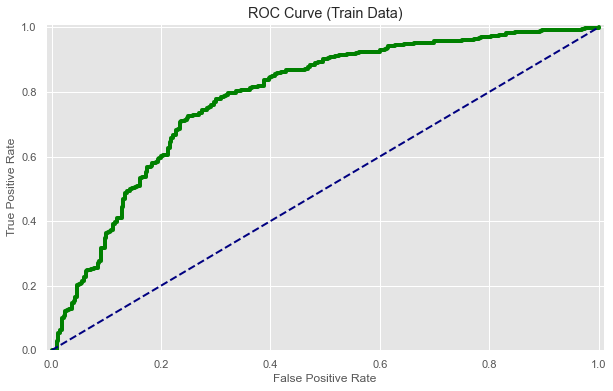

Optimal threshold value: 0.6988784602369129


In [253]:
y_scores = cross_val_predict(multinomialNB_clf, X_train, y_train, method="predict_proba", cv=5)[:, 1]

fpr_MNBTrain, tpr_MNBTrain, thresholds_MNBTrain = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr_MNBTrain, tpr_MNBTrain)
plt.show()

val = np.argmax(tpr_MNBTrain - fpr_MNBTrain)
optimal_threshold = thresholds_MNBTrain[val]
print("Optimal threshold value:", optimal_threshold)

In [254]:
# Area under ROC curve
roc_auc_score(y_train,y_scores)

0.784609375

In [255]:
y_test_predicted = multinomialNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = ", f1_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Confusion Matrix:
[[44 36]
 [ 9 71]]

Test Precision =  0.71875

Test Recall =  0.71875

Test F1 Score =  0.71875

Accuracy:  0.71875

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.55      0.66        80
           1       0.66      0.89      0.76        80

    accuracy                           0.72       160
   macro avg       0.75      0.72      0.71       160
weighted avg       0.75      0.72      0.71       160



### ROC Curve for test data.

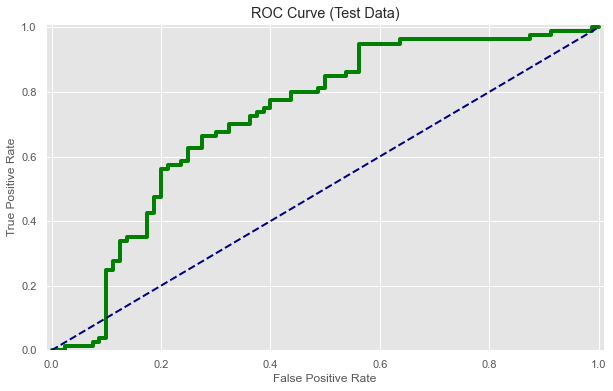

Optimal threshold value: 0.784751168744838


In [256]:
y_scores = cross_val_predict(multinomialNB_clf, X_test, y_test, method="predict_proba", cv=5)[:, 1]

fpr_MNBTest, tpr_MNBTest, thresholds_MNBTest = roc_curve(y_test, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr_MNBTest, tpr_MNBTest)
plt.show()

val = np.argmax(tpr_MNBTest - fpr_MNBTest)
optimal_threshold = thresholds_MNBTest[val]
print("Optimal threshold value:", optimal_threshold)

In [257]:
# Area under ROC curve
roc_auc_score(y_test,y_scores)

0.72390625

### KNN (Model selection)

In [258]:
# The param_grid evaluates all combinations of the hyperparameter values
param_grid = {'n_neighbors': [3, 4, 5, 9], 'p': [1, 2, 1000], 'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='recall', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Recall Score: ", knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


Best Recall Score:  0.9125
Optimal Hyperparameter Values:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}




[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


In [310]:
knn_clf = KNeighborsClassifier(n_neighbors=3, p = 1, weights='distance')

knn_clf.fit(X_train, y_train)

y_test_predicted_knn = knn_clf.predict(X_test)

### Plot the ROC curve for the training set

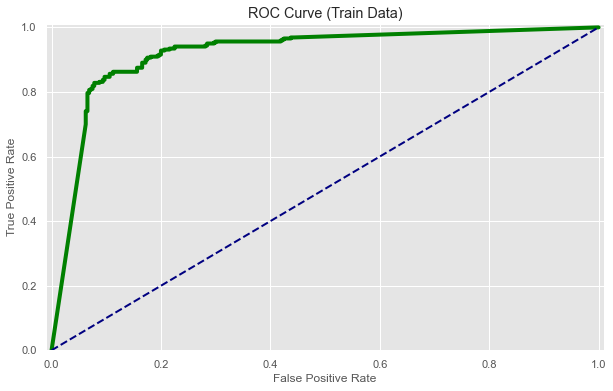

Optimal threshold value: 0.6951607239395752


In [311]:
y_scores = cross_val_predict(knn_clf, X_train, y_train, method="predict_proba", cv=5)[:, 1]

fpr_KNNTrain, tpr_KNNTrain, thresholds_KNNTrain = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr_KNNTrain, tpr_KNNTrain)
plt.show()

val = np.argmax(tpr_KNNTrain - fpr_KNNTrain)
optimal_threshold = thresholds_KNNTrain[val]
print("Optimal threshold value:", optimal_threshold)

In [312]:
# Area under ROC curve
roc_auc_score(y_train, y_scores)

0.919462890625

In [313]:
accuracy_score_test = np.mean(y_test_predicted_knn == y_test)

print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_knn))

precision_test = precision_score(y_test, y_test_predicted_knn, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted_knn, average='micro')
print("\nTest Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted_knn, average='micro')
print("\nTest F1 Score = ", f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_knn))


Accuracy:  0.8625

Test Confusion Matrix:
[[62 18]
 [ 4 76]]

Test Precision =  0.8625

Test Recall =  0.8625

Test F1 Score =  0.8625

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        80
           1       0.81      0.95      0.87        80

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160



### Plot the ROC curve for the test set

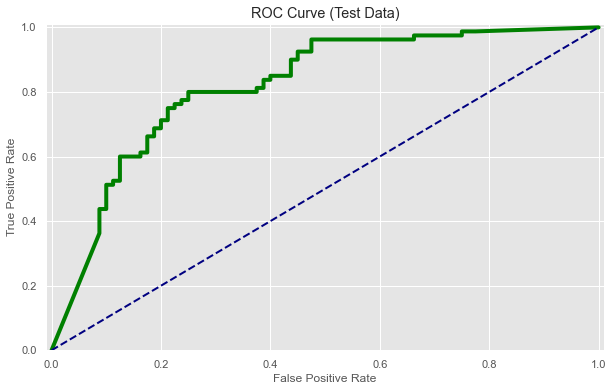

Optimal threshold value: 0.6664716785377279


In [314]:
y_scores = cross_val_predict(knn_clf, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_KNNTest, tpr_KNNTest, thresholds_KNNTest = roc_curve(y_test, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr_KNNTest, tpr_KNNTest)
plt.show()

val = np.argmax(tpr_KNNTest - fpr_KNNTest)
optimal_threshold = thresholds_KNNTest[val]
print("Optimal threshold value:", optimal_threshold)

In [315]:
# Area under ROC curve
roc_auc_score(y_test, y_scores)

0.819765625

### SVM (Linear model)

In [265]:
scaler = StandardScaler()

svm_clf = LinearSVC(C=1, loss="hinge", random_state=0, max_iter=5000)

scaled_svm_clf = Pipeline([("scaler", scaler), ("linear_svc", svm_clf),])


scaled_svm_clf.fit(X_train, y_train)

y_train_predicted = scaled_svm_clf.predict(X_train)

print("Training Accuracy: ", scaled_svm_clf.score(X_train, y_train))
y_test_predicted = scaled_svm_clf.predict(X_test)

print("Test Accuracy: ", scaled_svm_clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("Test Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("Test F1 Score = ", f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Training Accuracy:  0.865625
Test Accuracy:  0.8625

Test Confusion Matrix:
[[70 10]
 [12 68]]

Test Precision =  0.8625
Test Recall =  0.8625
Test F1 Score =  0.8625

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        80
           1       0.87      0.85      0.86        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



### Plot the ROC curve for the training set.

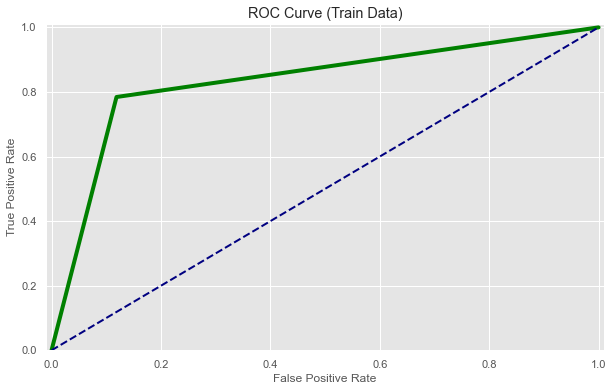

Optimal threshold value: 1


In [266]:
y_scores = cross_val_predict(scaled_svm_clf, X_train, y_train, cv=3)

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr, tpr)
plt.show()

val = np.argmax(tpr - fpr)
optimal_threshold = thresholds[val]
print("Optimal threshold value:", optimal_threshold)

In [267]:
# Area under ROC curve
roc_auc_score(y_train, y_scores)

0.8328125

### Plot the ROC curve for the test set.

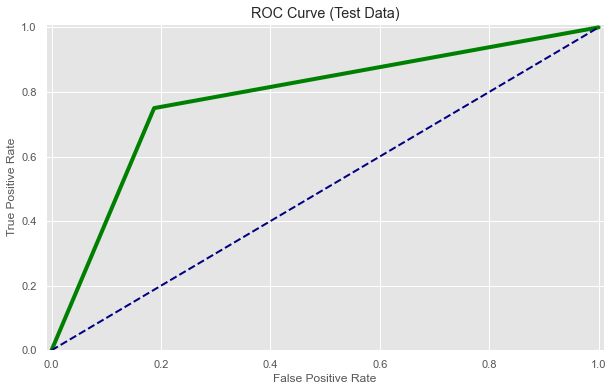

Optimal threshold value: 1


In [268]:
y_scores = cross_val_predict(scaled_svm_clf, X_test, y_test, cv=3)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr, tpr)
plt.show()

val = np.argmax(tpr - fpr)
optimal_threshold = thresholds[val]
print("Optimal threshold value:", optimal_threshold)


In [269]:
# Area under ROC curve
roc_auc_score(y_test, y_scores)

0.78125

## SVM (Polynomial)

In [270]:
X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [173]:
degreeList = [1, 2, 3, 5]

accuracy_train, accuracy_val = [], []

for degree in degreeList:
    
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), 
                          LinearSVC(C=1, loss="hinge", random_state=0)) 

    model.fit(X_train_fold, y_train_fold)

    # Make prediction 
    y_train_predicted = model.predict(X_train_fold)
    y_val_predicted = model.predict(X_val_fold)


    accuracy_train.append(model.score(X_train_fold, y_train_fold))
    accuracy_val.append(model.score(X_val_fold, y_val_fold))


# Find the value of degree that gives max validation accuracy
j = 0
max_val_accuracy = accuracy_val[j]
optimal_degree = 1

for i in degreeList:
    if(accuracy_val[j] > max_val_accuracy):
        max_val_accuracy = accuracy_val[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)
print("\n")

Optimal Degree:  1




In [271]:
optimal_poly_degree = 3

scaled_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=optimal_poly_degree)),
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1, loss="hinge", random_state=42))
    ])


scaled_svm_clf.fit(X, y)

y_train_predicted = scaled_svm_clf.predict(X_train)


print("Training Accuracy: ", scaled_svm_clf.score(X_train, y_train))

y_test_predicted = scaled_svm_clf.predict(X_test)
print("Test Accuracy: ", scaled_svm_clf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = ", f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Training Accuracy:  0.934375
Test Accuracy:  0.94375

Test Confusion Matrix:
[[74  6]
 [ 3 77]]

Test Precision =  0.927710843373494
Test Recall =  0.9625
Test F1 Score =  0.9447852760736196

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        80
           1       0.93      0.96      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



## Plot the training data

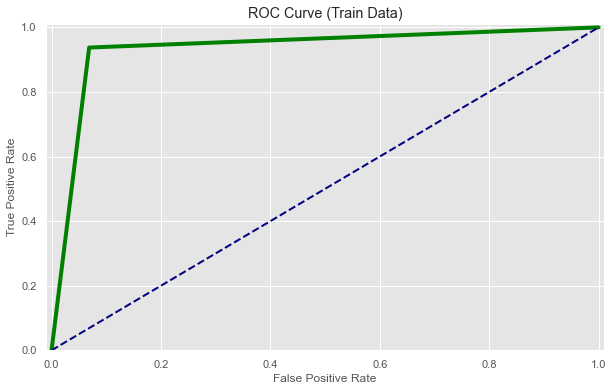

Optimal threshold value: 1


In [272]:
fpr_SVMTrain, tpr_SVMTrain, thresholds_SVMTrain = roc_curve(y_train, y_train_predicted)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr_SVMTrain, tpr_SVMTrain)
plt.show()

val = np.argmax(tpr_SVMTrain - fpr_SVMTrain)
optimal_threshold = thresholds_SVMTrain[val]
print("Optimal threshold value:", optimal_threshold)

In [273]:
# Area under ROC curve
roc_auc_score(y_train, y_train_predicted)

0.9343750000000001

## Plot the test data

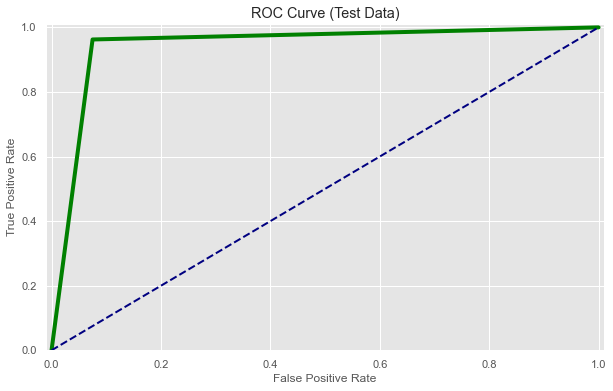

Optimal threshold value: 1


In [274]:
fpr_SVMTest, tpr_SVMTest, thresholds_SVMTest = roc_curve(y_test, y_test_predicted)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr_SVMTest, tpr_SVMTest)
plt.show()

val = np.argmax(tpr_SVMTest - fpr_SVMTest)
optimal_threshold = thresholds_SVMTest[val]
print("Optimal threshold value:", optimal_threshold)

In [275]:
# Area under ROC curve
roc_auc_score(y_test, y_test_predicted)

0.9437500000000001

## Logistic Regression

In [276]:
# instantiate the model
log_clf = LogisticRegression(solver="lbfgs", random_state=4)  
score = cross_val_score(log_clf, X_train, y_train, cv=10, verbose=3)
score.mean()

param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
model_lr = GridSearchCV(log_clf, param_grid, cv=10)
logisticR_clf = model_lr.fit(X_train, y_train)  # fit the optimal model

# find the optimal hyperparameters

print('Best Penalty:', logisticR_clf.best_estimator_.get_params()['penalty'])
print('Best C:', logisticR_clf.best_estimator_.get_params()['C'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.891, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.781, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.844, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.859, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.891, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.828, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.828, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Best Penalty: l2
Best C: 100


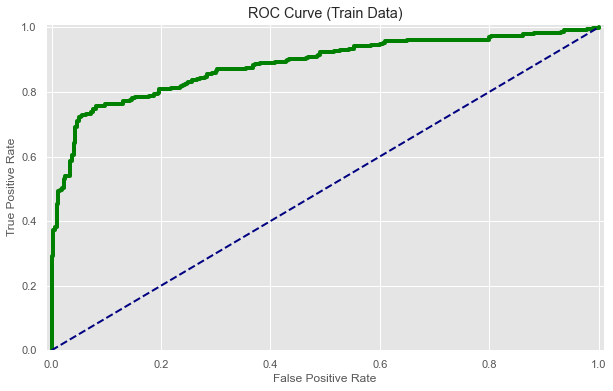

Optimal threshold value: 0.5907612216787637


In [277]:
y_scores = cross_val_predict(logisticR_clf, X_train, y_train, method="predict_proba", cv=5)[:, 1]

fpr_lrTrain, tpr_lrTrain, thresholds_lrTrain = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr_lrTrain, tpr_lrTrain)
plt.show()

val = np.argmax(tpr_lrTrain - fpr_lrTrain)
optimal_threshold = thresholds_lrTrain[val]
print("Optimal threshold value:", optimal_threshold)

In [278]:
# Area under ROC curve
roc_auc_score(y_train, y_scores)

0.883740234375

In [279]:
y_test_predicted = logisticR_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = ", f1_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Confusion Matrix:
[[73  7]
 [16 64]]

Test Precision =  0.85625

Test Recall =  0.85625

Test F1 Score =  0.85625

Accuracy:  0.85625

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        80
           1       0.90      0.80      0.85        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



### Plot the ROC Curve for the test set

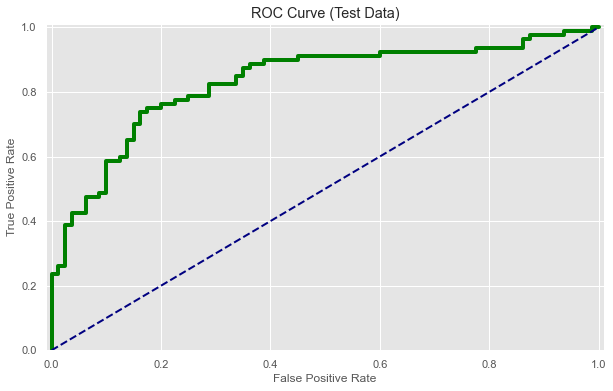

Optimal threshold value: 0.5202730371482756


In [280]:
y_scores = cross_val_predict(logisticR_clf, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_lrTest, tpr_lrTest, thresholds_lrTest = roc_curve(y_test, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr_lrTest, tpr_lrTest)
plt.show()

val = np.argmax(tpr_lrTest - fpr_lrTest)
optimal_threshold = thresholds_lrTest[val]
print("Optimal threshold value:", optimal_threshold)

In [281]:
# Area under ROC curve
roc_auc_score(y_test, y_scores)

0.8315625

## Multi-layer perceptron MLP

In [282]:
scaler = StandardScaler()  

# fit only on the training data
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)  

# apply same transformation to test data
X_test_scaled = scaler.transform(X_test)

In [283]:
param_grid = {'hidden_layer_sizes': [(3,), (5,), (10,)], 'solver':['sgd', 'lbfgs'], 
              'alpha': (0.1, 0.01, 0.001),'activation': ['logistic', 'relu'], 'tol': (0.001, 0.0001),
             'learning_rate': ['adaptive', 'constant']}

clf_mlp = MLPClassifier()

clf_mlp_cv = GridSearchCV(clf_mlp, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
clf_mlp_cv.fit(X_train_scaled, y_train)


params_optimal_mlp = clf_mlp_cv.best_params_

print("Best Score (accuracy):", clf_mlp_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_mlp)
print("\n")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.7s


Best Score (accuracy): 0.853125
Optimal Hyperparameter Values:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (3,), 'learning_rate': 'adaptive', 'solver': 'lbfgs', 'tol': 0.0001}




[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   12.0s finished


In [286]:
mlp_clf = MLPClassifier(random_state=0, hidden_layer_sizes=(3, ), alpha=0.01, solver='lbfgs',
                      max_iter=100, learning_rate='adaptive', activation='relu',
                    verbose=True)


mlp_clf.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(3,), learning_rate='adaptive',
              max_iter=100, random_state=0, solver='lbfgs', verbose=True)

In [287]:
print("No. of Iterations:", mlp_clf.n_iter_ )

y_train_predicted = mlp_clf.predict(X_train_scaled)

train_accuracy_mlp = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_mlp)

No. of Iterations: 100

Training Accuracy:  0.8984375


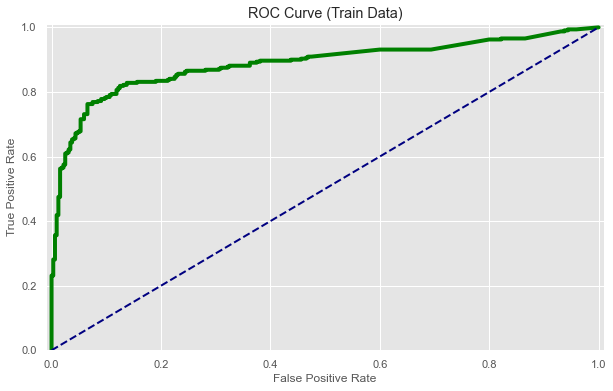

Optimal threshold value: 0.7591986664374087


In [288]:
y_scores = cross_val_predict(mlp_clf, X_train_scaled, y_train, method="predict_proba", cv=5)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr, tpr)
plt.show()

val = np.argmax(tpr - fpr)
optimal_threshold = thresholds[val]
print("Optimal threshold value:", optimal_threshold)

In [289]:
# Area under ROC curve
roc_auc_score(y_train, y_scores)

0.8869189453125

In [290]:
y_test_predicted = mlp_clf.predict(X_test_scaled)

test_accuracy_mlp = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_mlp)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision =", precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall =", recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score =", f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.90625

Test Confusion Matrix:
[[74  6]
 [ 9 71]]

Test Precision = 0.922077922077922
Test Recall = 0.8875
Test F1 Score = 0.9044585987261146

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        80
           1       0.92      0.89      0.90        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



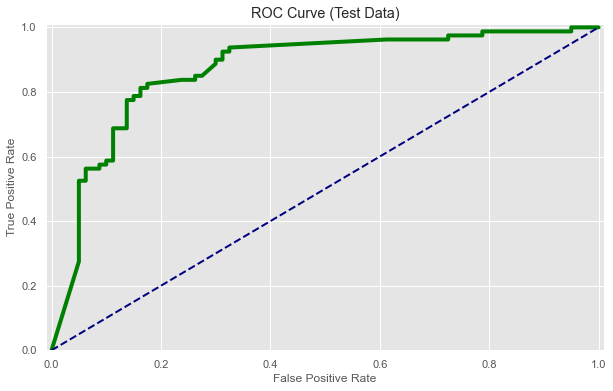

Optimal threshold value: 0.24669379584206583


In [291]:
y_scores = cross_val_predict(mlp_clf, X_test_scaled, y_test, method="predict_proba", cv=3)[:, 1]

fpr_MLPTest, tpr_MLPTest, thresholds_MLPTest = roc_curve(y_test, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr_MLPTest, tpr_MLPTest)
plt.show()

val = np.argmax(tpr_MLPTest - fpr_MLPTest)
optimal_threshold = thresholds_MLPTest[val]
print("Optimal threshold value:", optimal_threshold)

In [292]:
# Area under ROC curve
roc_auc_score(y_test, y_scores)

0.8697656249999999

## Random Forest

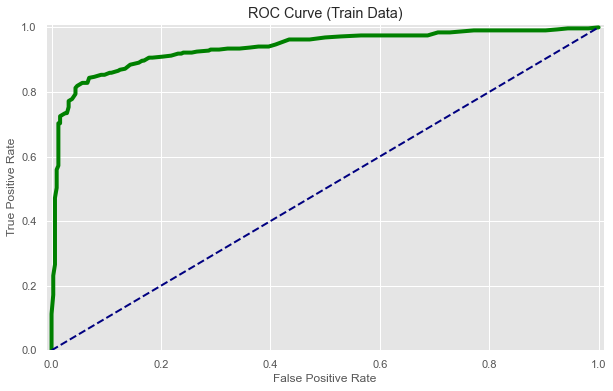

Optimal threshold value: 0.56


In [293]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=0)

forest_clf.fit(X_train, y_train)
y_scores_forest = cross_val_predict(forest_clf, X_train, y_train, cv=5, method="predict_proba")[:, 1]
fpr_forestTrain, tpr_forestTrain, thresholds_forestTrain = roc_curve(y_train,y_scores_forest)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr_forestTrain, tpr_forestTrain)
plt.show()

val = np.argmax(tpr_forestTrain - fpr_forestTrain)
optimal_threshold = thresholds_forestTrain[val]
print("Optimal threshold value:", optimal_threshold)

In [294]:
roc_auc_score(y_train, y_scores_forest)

0.9375292968750001

In [295]:
y_test_predicted = forest_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = ", f1_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))



Test Confusion Matrix:
[[73  7]
 [11 69]]

Test Precision =  0.8875

Test Recall =  0.8875

Test F1 Score =  0.8875

Accuracy:  0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        80
           1       0.91      0.86      0.88        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



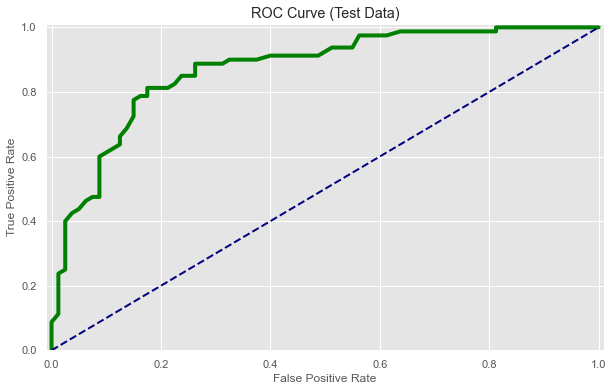

Optimal threshold value: 0.56


In [296]:
y_scores_forest = cross_val_predict(forest_clf, X_test, y_test, cv=5, method="predict_proba")[:, 1]
fpr_forestTest, tpr_forestTest, thresholds_forestTest = roc_curve(y_test,y_scores_forest)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_test(fpr_forestTest, tpr_forestTest)
plt.show()

val = np.argmax(tpr_forestTest - fpr_forestTest)
optimal_threshold = thresholds_forestTest[val]
print("Optimal threshold value:", optimal_threshold)

In [297]:
roc_auc_score(y_test, y_scores_forest)

0.8716406250000001

## Decision Tree

In [298]:
tree_clf = DecisionTreeClassifier(random_state=0)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(tree_clf, params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_

tree_clf.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    4.4s finished


DecisionTreeClassifier(random_state=0)

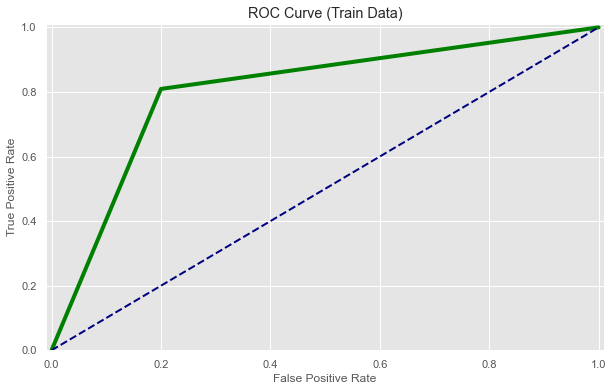

Optimal threshold value: 1.0


In [299]:
y_scores = cross_val_predict(tree_clf, X_train, y_train, cv=5, method="predict_proba")[:, 1]
fpr_treeTrain, tpr_treeTrain, thresholds_treeTrain = roc_curve(y_train, y_scores)


plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve_train(fpr_treeTrain, tpr_treeTrain)
plt.show()

val = np.argmax(tpr_treeTrain - fpr_treeTrain)
optimal_threshold = thresholds_treeTrain[val]
print("Optimal threshold value:", optimal_threshold)

In [300]:
roc_auc_score(y_train, y_scores)

0.8046875


Test Confusion Matrix:
[[62 18]
 [13 67]]

Test Precision =  0.80625

Test Recall =  0.80625

Test F1 Score =  0.8062499999999999

Accuracy:  0.80625

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        80
           1       0.79      0.84      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



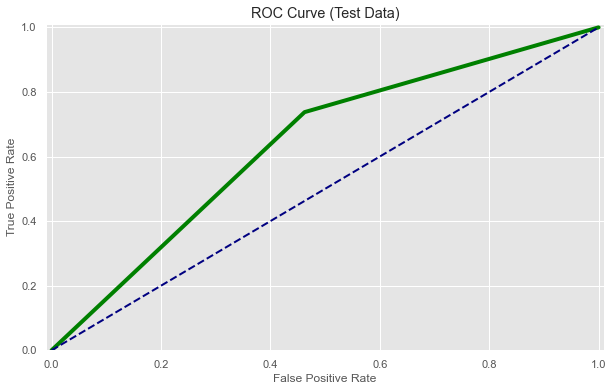

Optimal threshold value: 1.0


In [301]:
y_test_predicted = tree_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = ", precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = ", recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = ", f1_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

y_scores = cross_val_predict(tree_clf, X_test, y_test, cv=5, method="predict_proba")[:, 1]
fpr_treeTest, tpr_treeTest, thresholds_treeTest = roc_curve(y_test, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))    
plot_roc_curve_test(fpr_treeTest, tpr_treeTest)
plt.show()

val = np.argmax(tpr_treeTest - fpr_treeTest)
optimal_threshold = thresholds_treeTest[val]
print("Optimal threshold value:", optimal_threshold)

In [302]:
roc_auc_score(y_test, y_scores)

0.6375

In [303]:
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

voting_clf = VotingClassifier(
    estimators=[('Multinomial NB', multinomialNB_clf), 
                ('Random Forest', forest_clf), ('Multi-layer Perceptron', mlp_clf)],
                voting='hard')

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('Multinomial NB', MultinomialNB(alpha=1e-06)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=0)),
                             ('Multi-layer Perceptron',
                              MLPClassifier(alpha=0.01, hidden_layer_sizes=(3,),
                                            learning_rate='adaptive',
                                            max_iter=100, random_state=0,
                                            solver='lbfgs', verbose=True))])

In [304]:

for clf in (multinomialNB_clf, forest_clf, mlp_clf, voting_clf):
   # clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

MultinomialNB 0.71875
RandomForestClassifier 0.8875
MLPClassifier 0.50625
VotingClassifier 0.75625


In [306]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.84375


In [307]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.825


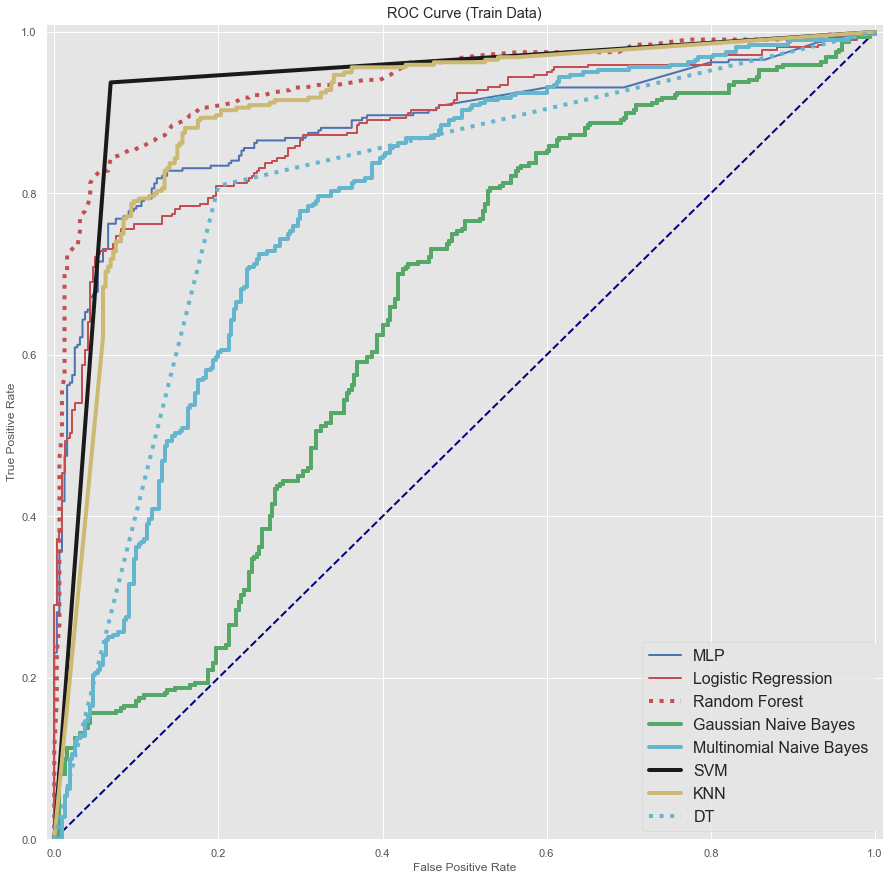

In [308]:
plt.figure(figsize=(15, 15))
plt.plot(fpr, tpr, "b", linewidth=2, label="MLP")
plt.plot(fpr_lrTrain, tpr_lrTrain, "r", linewidth=2, label="Logistic Regression")
plt.plot(fpr_forestTrain, tpr_forestTrain, "r:", linewidth=4, label="Random Forest")
plot_roc_curve_train(fpr_GNBTrain, tpr_GNBTrain)
plt.plot(fpr_GNBTrain, tpr_GNBTrain, "g-", linewidth=4, label="Gaussian Naive Bayes")
plt.plot(fpr_MNBTrain, tpr_MNBTrain, "c", linewidth=4, label="Multinomial Naive Bayes")
plt.plot(fpr_SVMTrain, tpr_SVMTrain, "k", linewidth=4, label="SVM")
plt.plot(fpr_KNNTrain, tpr_KNNTrain, "y", linewidth=4, label="KNN")
plt.plot(fpr_treeTrain, tpr_treeTrain, "c:", linewidth=4, label="DT")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

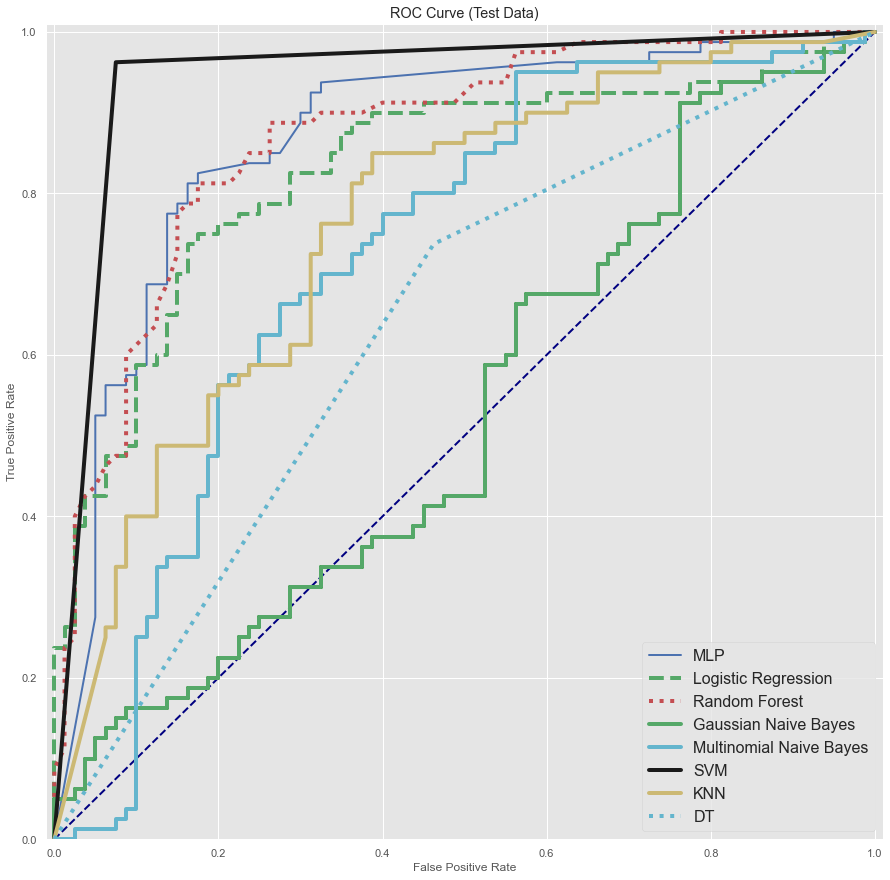

In [309]:
plt.figure(figsize=(15, 15))
plt.plot(fpr_MLPTest, tpr_MLPTest, "b", linewidth=2, label="MLP")
plt.plot(fpr_lrTest, tpr_lrTest, "g--", linewidth=4, label="Logistic Regression")
plt.plot(fpr_forestTest, tpr_forestTest, "r:", linewidth=4, label="Random Forest")
plot_roc_curve_test(fpr_GNBTest, tpr_GNBTest)
plt.plot(fpr_GNBTest, tpr_GNBTest, "g", linewidth=4, label="Gaussian Naive Bayes")
plt.plot(fpr_MNBTest, tpr_MNBTest, "c", linewidth=4, label="Multinomial Naive Bayes")
plt.plot(fpr_SVMTest, tpr_SVMTest, "k", linewidth=4, label="SVM")
plt.plot(fpr_KNNTest, tpr_KNNTest, "y", linewidth=4, label="KNN")
plt.plot(fpr_treeTest, tpr_treeTest, "c:", linewidth=4, label="DT")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()